In [1]:
import pandas as pd
import csv
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.svm import SVC
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

In [2]:
# set access  to google drive
from google.colab import drive
mount_path = '/content/gdrive'
drive.mount(mount_path)

Mounted at /content/gdrive


In [4]:
# uplod datasets
path = '/My Drive/HARdataset/UCI HAR Dataset'
cols = pd.read_csv(mount_path + path + '/features.txt',delim_whitespace=True,header=None)
x_train = pd.read_table(mount_path + path + '/train/X_train.txt', delim_whitespace=True,header=None)
y_train = pd.read_table(mount_path + path + '/train/y_train.txt',delim_whitespace=True,header=None)
x_test = pd.read_csv(mount_path + path + "/test/X_test.txt",delim_whitespace=True,header=None)
y_test = pd.read_csv(mount_path + path + '/test/y_test.txt',delim_whitespace=True,header=None)
subject_train = pd.read_table(mount_path + path + '/train/subject_train.txt', delim_whitespace=True,header=None)

with open(mount_path + path + '/activity_labels.txt', 'r') as csvin:
    reader=csv.reader(csvin, delimiter=' ')
    labels={k:v for k,v in reader}

In [5]:
len (subject_train.value_counts())

21

([<matplotlib.patches.Wedge at 0x7fa853122fd0>,
 [Text(0.9524712242532563, 0.550271357576881, 'WALKING'),
  Text(0.07092716382579896, 1.0977109534989749, 'WALKING_UPSTAIRS'),
  Text(-0.8007319604776209, 0.7542070852688048, 'WALKING_DOWNSTAIRS'),
  Text(-1.074588337293393, -0.23507425497706272, 'SITTING'),
  Text(-0.2387464551990766, -1.0737784362380702, 'STANDING'),
  Text(0.9071063478450202, -0.6222202774735562, 'LAYING')],
 [Text(0.5195297586835943, 0.3001480132237532, '16.68'),
  Text(0.03868754390498124, 0.5987514291812589, '14.59'),
  Text(-0.4367628875332477, 0.41138568287389343, '13.41'),
  Text(-0.5861390930691235, -0.12822232089657964, '17.49'),
  Text(-0.1302253391994963, -0.5856973288571291, '18.69'),
  Text(0.49478528064273825, -0.33939287862193973, '19.14')])

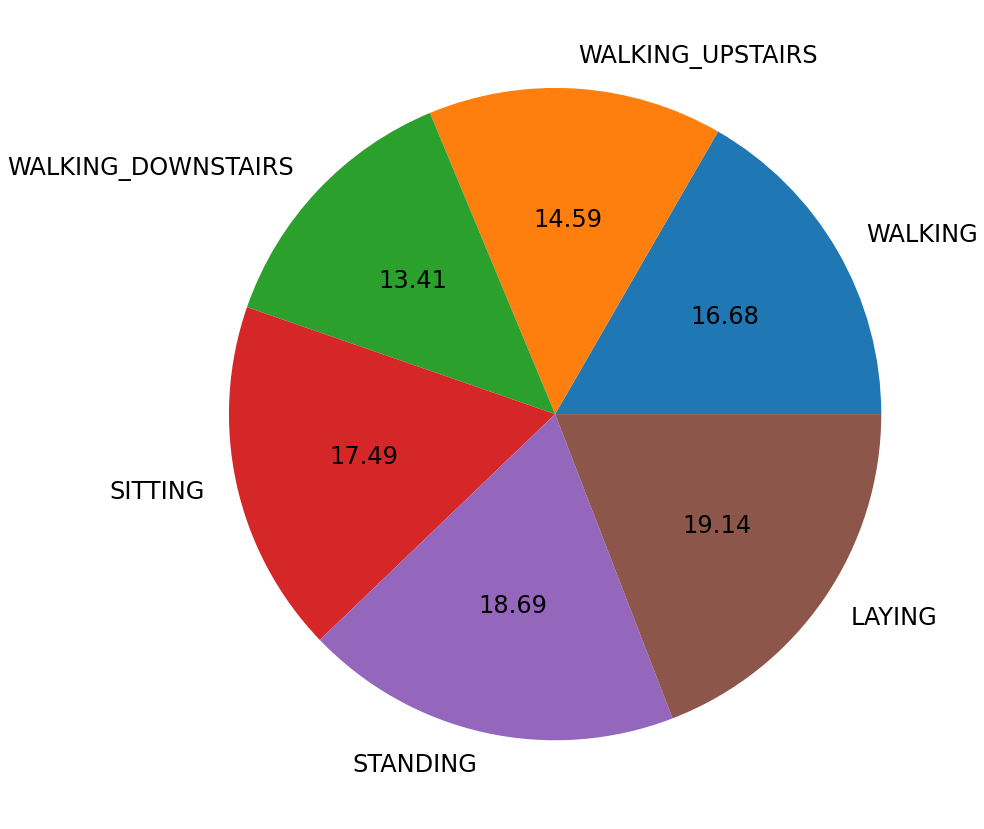

In [6]:
# Count each label to check whether the data is balanced 
distribution={int(i[0]): y_train.value_counts(sort=False)[i]for i in y_train.value_counts(sort=False).index}

# Plot a pie chart for different activities
plt.rcParams.update({'figure.figsize': [15, 15], 'font.size': 24})
plt.pie(distribution.values(), labels = labels.values(), autopct = '%0.2f')

In [ ]:
# Labels of the data are balanced, YAY! we don't need to deal with data imbalance.

In [7]:
# Define and fit Support Vector Classifier
# An algorithm that analyze data for classification
# SVM is more effective in high dimensional spaces.
svc = SVC().fit(x_train, y_train)
prediction = svc.predict(x_test)
# Print the results
SVC_accuracy = accuracy_score(y_test, prediction)*100     # Accuracy = (TP + TN)/(TP + TN + FP + FN)     count the good predictions out of all predictions 
SVC_f1 = f1_score(y_test, prediction, average= "macro")*100   # harmonic mean of Precision and Recall 2*((Precision*Recall) / (Precision+Recall))
                                                              # gives a better measure of the incorrectly classified cases than the Accuracy Metric, 
                                                              # because it take into account the  false negatives and false positives, both of have similar meaning
print('Support Vector Classifier accuracy: {:.2f}%'.format(SVC_accuracy))
print('Support Vector Classifier f1 score: {:.2f}%'.format(SVC_f1))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Support Vector Classifier accuracy: 95.05%
Support Vector Classifier f1 score: 94.99%




# We get really good results. Our model classify correctly in 95% of the cases



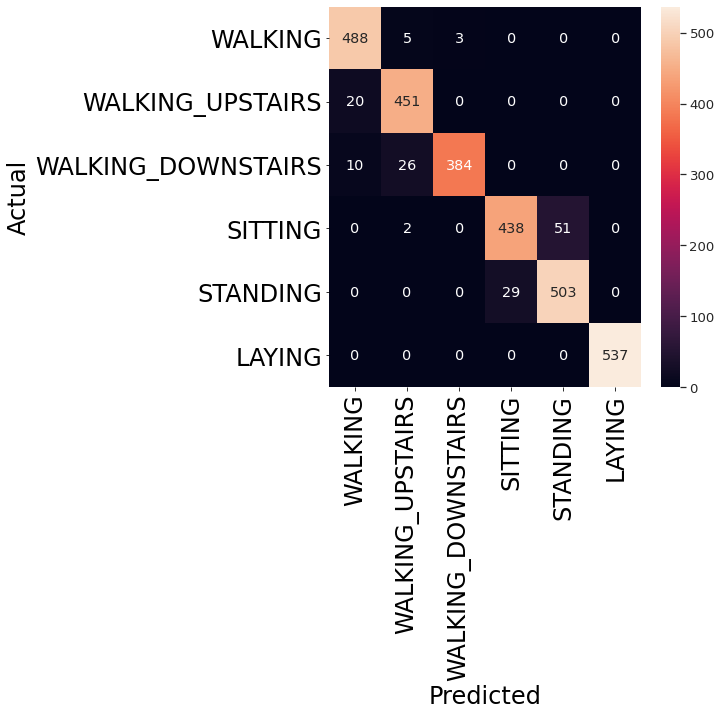

In [8]:
# hitmap to see performence of SVC model
cm_svc = pd.DataFrame(y_test)
cm_svc=cm_svc.rename(columns={0:'y_Actual'})
cm_svc['y_Predicted']=prediction
confusion_matrix = pd.crosstab(cm_svc['y_Actual'], cm_svc['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
fig, ax = plt.subplots(figsize=(7,7))  
sns.set(font_scale=1.2)
sns.heatmap(confusion_matrix, annot=True, fmt="g", xticklabels=labels.values(),yticklabels=labels.values())
plt.show()

# One may see that the algorithm is pretty accurate without mistakes between movement activities and activities without movement. There are few mistakes between movement activities (one kind of walking falsely predicted as another kind of walking), and between the non-movement activities (sitting falsely predicted as standing and vice versa). There are no mistakes with laying, possibly because the diffrence in posture

In [9]:
# Load and pre process the raw data to the LSTM model
# LSTM predicts the next step based on previous steps, so we need the sequential data. LSTM can learn from the raw time series data directly
signals_XYZ = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_"
]

X_train_signals_paths = [
    mount_path + path + '/train/Inertial Signals/' + signal + "train.txt" for signal in signals_XYZ
]
X_test_signals_paths = [
    mount_path + path + '/test/Inertial Signals/' + signal + "test.txt" for signal in signals_XYZ
]


def load_X(X_signals_paths):
    X_signals = []

    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()

    return np.transpose(np.array(X_signals), (1, 2, 0))

raw_x_train = load_X(X_train_signals_paths)
raw_x_test = load_X(X_test_signals_paths)

In [10]:
# convert y to one hot encoder, suitable to the LSTM output
e = OneHotEncoder(sparse=False)

e = e.fit(y_train)

y_train_e = e.transform(y_train)
y_test_e = e.transform(y_test)

In [33]:
#Build the model. 
# Bidirectional LSTM  consists of two LSTMs: one analyze the activity sequence in a forward direction, and the other in a backwards direction.
# It improve performances of the motionless activities (sitting, standing and laying)
model = keras.Sequential()
model.add(Bidirectional(
              LSTM(
                    units=128,input_shape=[raw_x_train.shape[1], raw_x_train.shape[2]])))
model.add(Dropout(rate=0.3))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(y_train_e.shape[1], activation='softmax'))

#define small learning rate for better reaching to the global minimum of the gradient.
adam=optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(
  loss='categorical_crossentropy',
  optimizer=adam,
  metrics=['acc']
)

In [34]:
history = model.fit(raw_x_train, y_train_e, epochs=150,
    batch_size=32, validation_data=(raw_x_test, y_test_e)
)

Epoch 1/150
230/230 [==============================] - 8s 21ms/step - loss: 1.7932 - acc: 0.2248 - val_loss: 1.7855 - val_acc: 0.2497
Epoch 2/150
230/230 [==============================] - 4s 18ms/step - loss: 1.7831 - acc: 0.2459 - val_loss: 1.7756 - val_acc: 0.2732
Epoch 3/150
230/230 [==============================] - 4s 18ms/step - loss: 1.7736 - acc: 0.2684 - val_loss: 1.7643 - val_acc: 0.2976
Epoch 4/150
230/230 [==============================] - 4s 18ms/step - loss: 1.7616 - acc: 0.2914 - val_loss: 1.7499 - val_acc: 0.3118
Epoch 5/150
230/230 [==============================] - 4s 18ms/step - loss: 1.7442 - acc: 0.3173 - val_loss: 1.7266 - val_acc: 0.3298
Epoch 6/150
230/230 [==============================] - 4s 19ms/step - loss: 1.7183 - acc: 0.3342 - val_loss: 1.6386 - val_acc: 0.3505
Epoch 7/150
230/230 [==============================] - 4s 18ms/step - loss: 1.6263 - acc: 0.3470 - val_loss: 1.5463 - val_acc: 0.3577
Epoch 8/150
230/230 [==============================] - 4s 18ms

In [35]:
# Argmax in order to calculate accurarcy and f1
prediction_2 = np.argmax(model.predict(raw_x_test),axis=1)+1
LSTM_accuracy = accuracy_score(y_test, prediction_2)*100
LSTM_f1 = f1_score(y_test, prediction_2, average= "macro")*100
print('Long Short-Term Memory accuracy: {:.2f}%'.format(LSTM_accuracy))
print('Long Short-Term Memory f1 score: {:.2f}%'.format(LSTM_f1))

Long Short-Term Memory accuracy: 59.86%
Long Short-Term Memory f1 score: 58.30%


In [29]:
# plot loss to see the fit process and evaluate the model
def plot_fit_logs(history):
    plt.title('Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

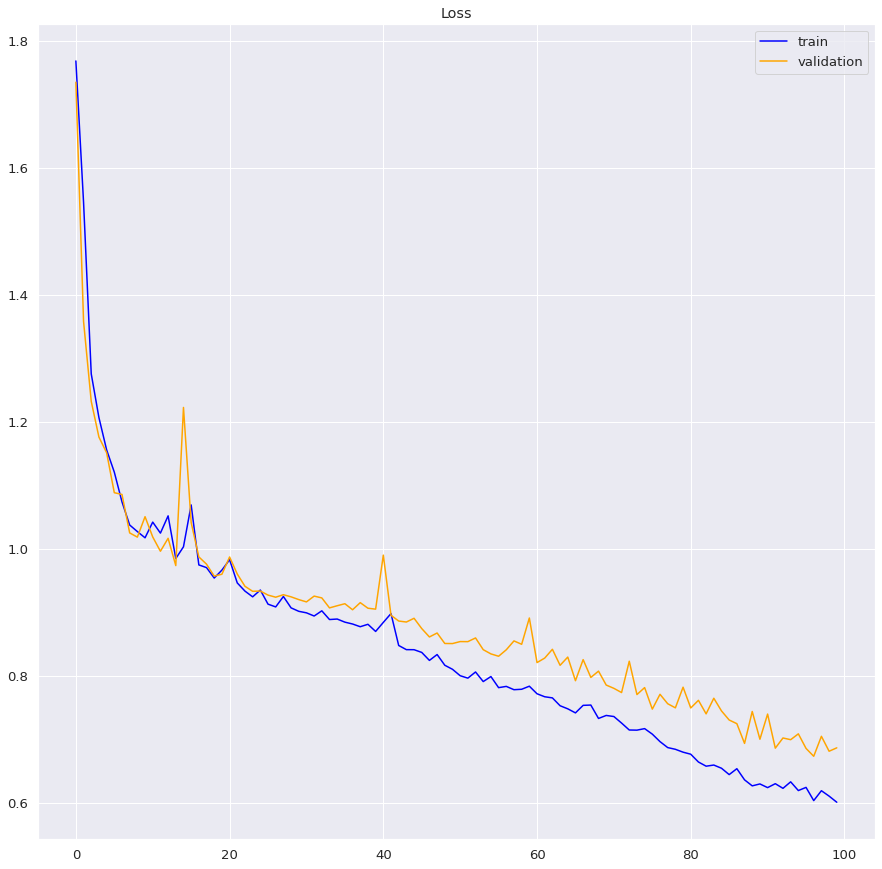

In [30]:
plot_fit_logs(history)

Althouth the accurarcy is not that good, the model is not overfit, the train and validation losses are similar.

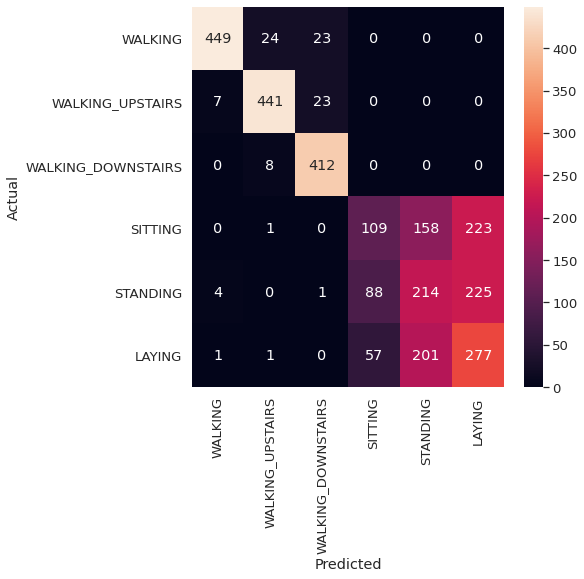

In [32]:
cm = pd.DataFrame(y_test)
cm=cm.rename(columns={0:'y_Actual'})
cm['y_Predicted']=prediction_2
confusion_matrix = pd.crosstab(cm['y_Actual'], cm['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
fig, ax = plt.subplots(figsize=(7,7))  
sns.set(font_scale=1.2)
sns.heatmap(confusion_matrix, annot=True, fmt="g", xticklabels=labels.values(),yticklabels=labels.values())
plt.show()
